# PROJET 6 : 
## Classifiez automatiquement des biens de consommation

### Contexte :

### Mission :

### Contraintes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from collections import Counter


from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import MiniBatchKMeans
from sklearn import manifold, decomposition
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import preprocessing
from sklearn import cluster, metrics

import tensorflow
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

import random
import mglearn
from spacy.lang.en import English

from PIL import Image, ImageOps, ImageFilter
import time, cv2
import os
from os import listdir
from matplotlib.image import imread

#from nltk.collocations import *
#nltk.download("book")

# *PARTIE 1 : Données "TEXTE"*
* Objectif : Vérifier si nous pouvons prédire la catégorie d'un produit en fonction de sa description

# 1. Traitement du texte

## 1.1. Chargement des données

In [2]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [3]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [4]:
data.shape

(1050, 15)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

## 1.2. Structure des données

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [7]:
def data_structure(data):
    ''' Cette fonction affiche une synthèse de la structure du dataframe'''
    
    # comptage des colonnes numériques et catégorielles
    numeric_columns = len(data.select_dtypes(include = ['float64']).columns)
    categorical_columns= len(data.select_dtypes(include=['object','bool']).columns)

    # création d'un dictionnaire avec les items de structure de nos données
    dict_structure = {'Nombre de lignes':data.shape[0], 'Nombre de colonnes':int(data.shape[1]), 
                      'Nombre de variables catégorielles':categorical_columns,
                      'Nombre de variables numériques ':numeric_columns,
                      'Pourcentage de données manquantes':int((data.isnull().sum()/len(data)*100).mean()),
                      'Nombre de doublons':int(len(data[data.duplicated()]))}

    # transformation des éléments du dictionnaire en dataframe
    dataframe =pd.DataFrame(list(dict_structure.items()),columns=['Caractéristiques','Valeurs'])
    return dataframe

In [8]:
# Stucture des données
data_structure(data)

Caractéristiques  Valeurs
0                   Nombre de lignes     1050
1                 Nombre de colonnes       15
2  Nombre de variables catégorielles       13
3    Nombre de variables numériques         2
4  Pourcentage de données manquantes        2
5                 Nombre de doublons        0

In [9]:
# Nombre de valeurs manquantes au total
print('Nombre de valeurs manquantes au total :{}'.format(data.isna().sum().sum()))

Nombre de valeurs manquantes au total :341


In [10]:
# Nombre de valeurs manquantes par colonne
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [11]:
data.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [12]:
# Nombre de catégories uniques
print("Nombre de catégories :{}".format(data['product_category_tree'].nunique()))

Nombre de catégories :642


## 1.3. Visualisation des colonnes qui nous intéressent

In [13]:
data["product_category_tree"][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [14]:
data["description"][0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [15]:
data["product_specifications"][0]

'{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}'

## 2. Exploration des données

### 2.1. Catégories de produits

In [16]:
df= data.loc[:, ["description", "product_category_tree"]]

# On crée une liste de strings en prenant les mots entre les >>
df1 = df["product_category_tree"].str.split(">>")

# Et on ne récupère que la deuxième valeur de la liste
# Ce qui correspondra à notre catégorie de produits
df["sous_cat_1"] = df1.apply(lambda x: x[0])
df["sous_cat_2"]= df1.apply(lambda x: x[1])

In [17]:
df.head()

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree          sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  ["Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        ["Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        ["Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  ["Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  ["Home Furnishing    

                 sous_cat_2  
0   Curtains & Accessories   
1         Baby Bath & Skin   
2         Baby Bath & Skin   
3                Bed Linen   
4                Bed Linen

In [18]:
print("Nombre d'items dans la sous-catégorie 1 :{}".format(len(df["sous_cat_1"].unique())))
print("Nombre d'items dans la sous-catégorie 2 :{}".format(len(df["sous_cat_2"].unique())))

Nombre d'items dans la sous-catégorie 1 :7
Nombre d'items dans la sous-catégorie 2 :63


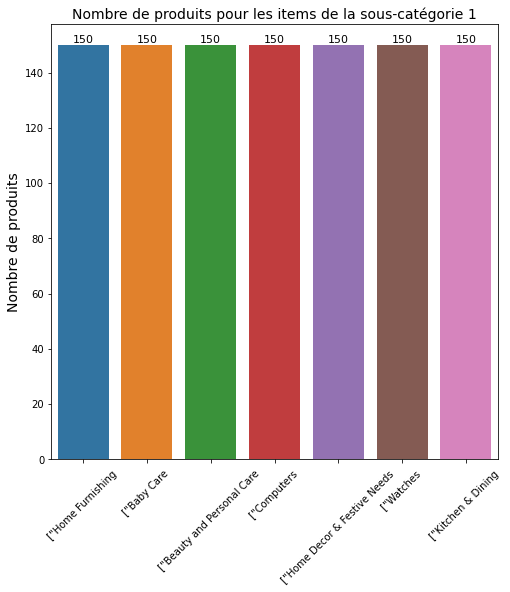

In [19]:
# On commence par faire le comptage de la sous catégorie 1
plt.figure(figsize=(8, 8))
    
plt.xticks(rotation=45)

val = df["sous_cat_1"].value_counts()
val = pd.DataFrame(val)

sns.barplot(x=val.index, y=val["sous_cat_1"])

plt.ylabel("Nombre de produits", size=14)
plt.title('Nombre de produits pour les items de la sous-catégorie 1', size = 14)

for i, v in enumerate(val["sous_cat_1"].values):
    plt.text(i, v+1, v, color='black', ha='center', size=11)


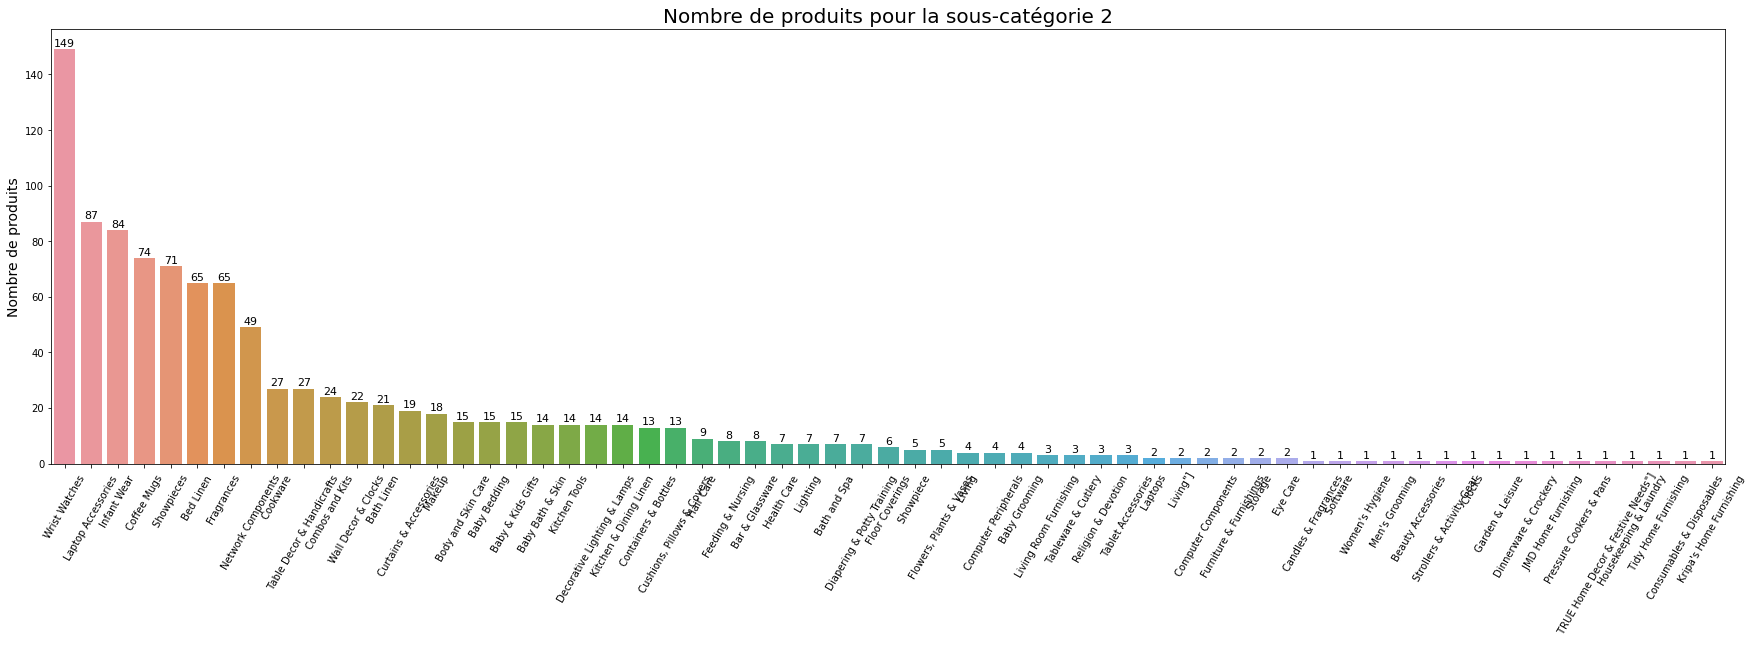

In [20]:
# On commence par faire le comptage de la sous catégorie 2
plt.figure(figsize=(30, 8))
    
plt.xticks(rotation=60)

val = df["sous_cat_2"].value_counts()
val = pd.DataFrame(val)

sns.barplot(x=val.index, y=val["sous_cat_2"])

plt.ylabel("Nombre de produits", size=14)
plt.title("Nombre de produits pour la sous-catégorie 2", size=20)

for i, v in enumerate(val["sous_cat_2"].values):
    plt.text(i, v+1, v, color='black', ha='center', size=11)

In [21]:
# Nous combinons l'ensemble des descriptions dans une variable string
all_des = ' '.join([text for text in df["description"]])

# Ce tokenizer ne capture que les mots capitalisés
capword_tokenizer = RegexpTokenizer("[A-Z]\w+")
all_des_tokened = capword_tokenizer.tokenize(all_des)

display("Nombre de mots au total dans les descriptions:", len(all_des_tokened))

'Nombre de mots au total dans les descriptions:'

41803

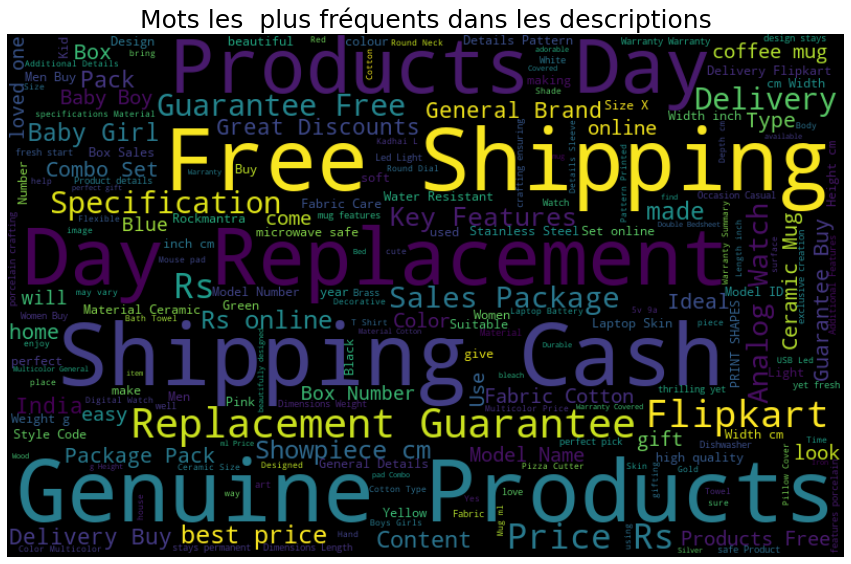

In [22]:
# Mots les plus fréquents dans les descriptions
wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(all_des)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Mots les  plus fréquents dans les descriptions", size=25)
plt.axis('off')
plt.show()

In [23]:
df["sous_cat_2"] = df["sous_cat_2"].str.strip()
des = df[df["sous_cat_2"] == "Wrist Watches"]

# On récupère toutes les descriptions de la catégorie
# On en forme une chaîne de caractères
des_text = ' '.join(text for text in des["description"])

# On fait une tokenisation de cette chaine
# avec le tokenizer construit précédemment
# On ne garde que les mots capitalisés
des_text_tokenized = capword_tokenizer.tokenize(des_text)

# On recrée une chaîne "propre"
des_text_tokenized = ' '.join(des_text_tokenized)

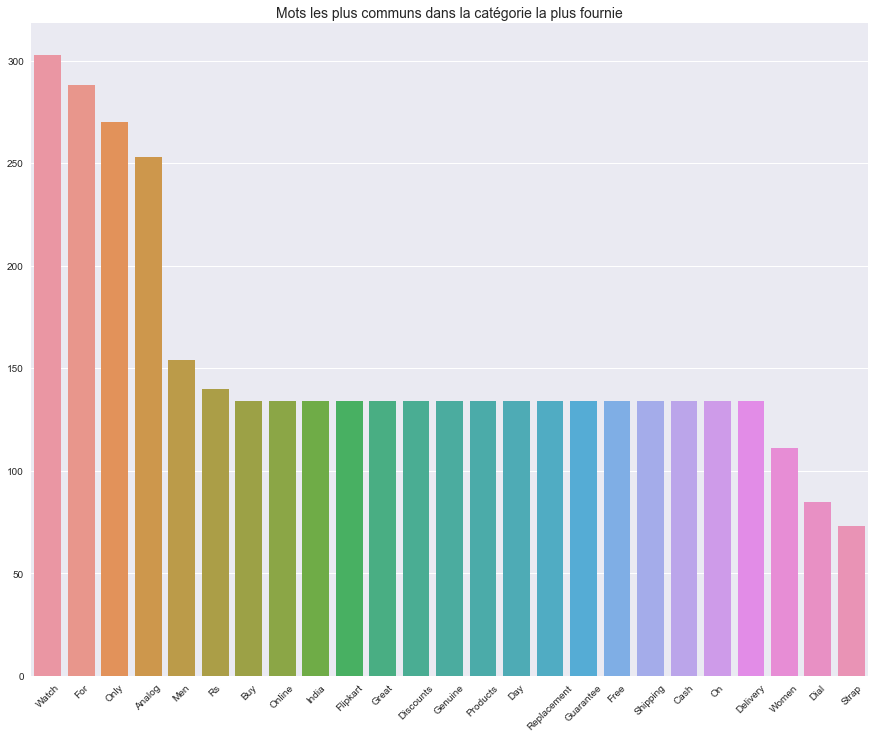

In [24]:
des_list = des_text_tokenized.split()
des_counts = Counter(des_list)
des_common_words = [word[0] for word in des_counts.most_common(25)]
des_common_counts = [word[1] for word in des_counts.most_common(25)]

plt.style.use('seaborn')
plt.figure(figsize=(15, 12))
plt.xticks(rotation=45)
sns.barplot(x=des_common_words, y=des_common_counts)
plt.title("Mots les plus communs dans la catégorie la plus fournie", size=14)
plt.show()

## 3. Nettoyage des données

### 3.1. Création de datasets d'apprentissages

In [25]:
# Création d'une fonction qui va nous permettre d'enlever les 2 chevrons devant les items de 
# la sous-catégorie 1

def clean_sous_cat_1(text):
    '''Cette fonction supprime les 2 premiers caractères d'un texte'''
    text = text[2:]
    return text

In [26]:
data_train = df["description"]
data_target = df["sous_cat_1"]

#On nettoie le nom des catégories
data_target = data_target.apply(clean_sous_cat_1)

print(data_train[:5])
print("------------------------")
print(data_target[:5])

0    Key Features of Elegance Polyester Multicolor ...
1    Specifications of Sathiyas Cotton Bath Towel (...
2    Key Features of Eurospa Cotton Terry Face Towe...
3    Key Features of SANTOSH ROYAL FASHION Cotton P...
4    Key Features of Jaipur Print Cotton Floral Kin...
Name: description, dtype: object
------------------------
0    Home Furnishing 
1          Baby Care 
2          Baby Care 
3    Home Furnishing 
4    Home Furnishing 
Name: sous_cat_1, dtype: object


### 3.2. Nettoyage de texte

#### 3.2.1. Suppression ponctuation et majuscules

In [27]:
def clean_description(description):
    
    # Ce tokenizer ne capture que les mots capitalisés
    capword_tokenizer = RegexpTokenizer("[A-Z]\w+")
    data_tokenized = capword_tokenizer.tokenize(description)
    
    # On recrée une chaîne "propre"
    data_tokenized = ' '.join(data_tokenized)
    
    return data_tokenized.lower()

In [28]:
data_train = data_train.apply(clean_description)
data_train[:5]

0    key features elegance polyester multicolor abs...
1    specifications sathiyas cotton bath towel bath...
2    key features eurospa cotton terry face towel s...
3    key features santosh royal fashion cotton prin...
4    key features jaipur print cotton floral king d...
Name: description, dtype: object

#### 3.2.2. Bag of words

In [29]:
# La fonction CountVectorizer de scikit learn permet d'extraire les mots d'un texte

def extract_mots(data, min_df, stopwords):
    
    vect = CountVectorizer(min_df=min_df, stop_words=stopwords).fit(data)
    X_train = vect.transform(data)
    
    return [vect, X_train]

#### 3.2.3. Suppression des Stop words

In [30]:
print("Nombre de stopwords :", len(ENGLISH_STOP_WORDS))
print("Tous les 10 stopwords :", list(ENGLISH_STOP_WORDS)[::10])

Nombre de stopwords : 318
Tous les 10 stopwords : ['hundred', 'per', 'mill', 'two', 'move', 'himself', 'any', 'whereafter', 'everywhere', 'de', 'anyway', 'five', 'his', 'would', 'one', 'afterwards', 'thus', 'hereafter', 'which', 'hereby', 'of', 'whole', 'made', 'there', 'the', 'interest', 'whoever', 'former', 'between', 'their', 'such', 'cant']


In [31]:
vect, X_train = extract_mots(data_train, 3, "english")

print("X_train:\n", format(repr(X_train)))

X_train:
 <1050x939 sparse matrix of type '<class 'numpy.int64'>'
	with 21352 stored elements in Compressed Sparse Row format>


#### 3.2.4. Lemmatisation

In [32]:
#w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
#lemmatizer = nltk.stem.WordNetLemmatizer()
#
#def lemma_tokenizer(document):
#    
#    doc_spacy = tokenizer(document)
#    
#    return [token.lemma_ for token in doc_spacy]

In [33]:
#en_nlp = English()
#tokenizer = en_nlp.Defaults.create_tokenizer(en_nlp)
#
#
#lemma_vect = TfidfVectorizer(min_df=3,
#                       stop_words="english",
#                       decode_error="ignore",
#                       ngram_range=(1,2),
#                       tokenizer=lemma_tokenizer)

In [34]:
#X_train_lemma = lemma_vect.fit_transform(data_train)
#print("Taille vocabulaire après lemmatisation :", X_train_lemma.shape)
#
#

### 3.3. Calcul performance 

In [35]:
def calcul_performance(X_train, data_target):
    
    param_dist = {'C': [0.001, 0.01, 0.1, 1, 10]}
    random_search = RandomizedSearchCV(LogisticRegression(),
                            param_distributions=param_dist,
                            cv=2,
                            iid=False)

    random_search.fit(X_train, data_target)
    
    return random_search

In [36]:
random_search = calcul_performance(X_train, data_target)

print("Mean Random Search accuracy:", random_search.best_score_)

C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Mean Random Search accuracy: 0.7933333333333333


#### 3.3.1. Pondération des données avec TF-IDF

In [37]:
pipe = make_pipeline(TfidfVectorizer(min_df=3,
                                     norm=None,
                                     stop_words="english"),
                     LogisticRegression())

param_dist = {"logisticregression__C": [0.01, 0.1, 1, 10, 100]}

random_search = RandomizedSearchCV(pipe,
                            param_distributions=param_dist,
                            cv=5,
                            iid=False)

random_search.fit(data_train, data_target)

print("Mean Random Search accuracy:", random_search.best_score_)

C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of

Mean Random Search accuracy: 0.8676190476190475


C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Analyses résultats Tf-idf

In [38]:
vectorizer = random_search.best_estimator_.named_steps["tfidfvectorizer"]
X_train = vectorizer.transform(data_train)

max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vectorizer.get_feature_names())

print("Features avec basse valeur :\n", feature_names[sorted_by_tfidf[:20]])
print("Features avec haute valeur :\n", feature_names[sorted_by_tfidf[-20:]])

Features avec basse valeur :
 ['rs' 'genuine' 'guarantee' 'delivery' 'cash' 'shipping' 'discounts' 'buy'
 'additional' 'id' 'flipkart' 'summary' 'specifications' 'clasp' 'general'
 'buckle' 'comforters' 'bleach' 'wireless' 'lowest']
Features avec haute valeur :
 ['crystal' 'fragrance' 'keyboard' 'artificial' 'battery' 'hair' 'buddha'
 'sofa' 'tree' 'copper' 'bed' 'bonsai' 'ocean' 'pot' 'cutter' 'skin' 'tea'
 'plant' 'pizza' 'bowl']


#### 3.3.2. Meilleurs n-gram

In [39]:
# Essayons TfidfVectorizer sur notre jeu de données, et trouvons la meilleur valeur possible pour la plage des n-grammes
# en utilisant une recherche sur grille.


pipe = make_pipeline(TfidfVectorizer(min_df=3,
                                     norm=None,
                                     stop_words="english"),
                     LogisticRegression())

param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
             "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe,
                    param_grid,
                    cv=5)

grid.fit(data_train, data_target)

print("Best Cross-validation score:", grid.best_score_)
print("Best parameters:\n", grid.best_params_)

C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Best Cross-validation score: 0.8752380952380951
Best parameters:
 {'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 2)}


C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


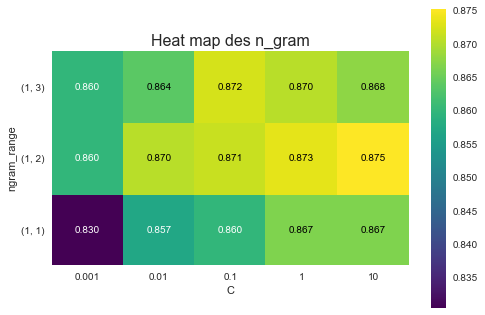

In [40]:
# Heatmap des n_gram permettant de visualiser ngram_range en fonction de C
scores = grid.cv_results_["mean_test_score"].reshape(-1, 3).T

heatmap = mglearn.tools.heatmap(scores,
                               xlabel="C",
                               ylabel="ngram_range",
                               cmap="viridis",
                               fmt="%.3f",
                               xticklabels=param_grid["logisticregression__C"],
                               yticklabels=param_grid["tfidfvectorizer__ngram_range"])
plt.title("Heat map des n_gram", size=16)

plt.colorbar(heatmap)
plt.show()

### 3.4. LDA (L'Allocation de Dirichlet latente)

In [41]:
vect = TfidfVectorizer(min_df=3,
                norm=None,
                stop_words="english",
                ngram_range=(1,2))

X = vect.fit_transform(data_train)

In [42]:
# Nous enregistrons les vecteurs calculés avec Tfidf dans notre dataframe df
tfidf_vect = X.toarray().astype("float32")

df["tf_idf"] = ""

for i in range(df.shape[0]):
    df["tf_idf"][i] = tfidf_vect[i]

df.head()

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree          sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  ["Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        ["Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        ["Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  ["Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  ["Home Furnishing    

               sous_cat_2                                             tf_idf  
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [43]:
# LDA

lda = LatentDirichletAllocation(n_components=7,
                                learning_method="batch",
                                max_iter=25,
                                random_state=0)

document_topics = lda.fit_transform(X)

In [44]:
print("lda_components.shape :", lda.components_.shape)
print("Nombre de sujets :", lda.components_.shape[0])
print("Nombre de mots :", lda.components_.shape[1])

lda_components.shape : (7, 2371)
Nombre de sujets : 7
Nombre de mots : 2371


### Représentation des caractéristiques de chaque sujet pour la sous-catégorie 1

In [45]:
# Utilisation de la fonction print_topics qui permet d'extraire les caractéristiques de chaque topic

sorting = np.argsort(lda.components_, axis=1)[:,::-1]
feature_names = np.array(vect.get_feature_names())

mglearn.tools.print_topics(topics=range(7),
                          feature_names=feature_names,
                          sorting=sorting,
                          topics_per_chunk=7,
                          n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       
--------      --------      --------      --------      --------      --------      --------      
usb           warranty      flipkart      usb           pack          steel         baby          
dress         ceramic       watch         mugs          features      pizza         details       
light         mug           genuine productssticker       model         maxima        baby girl     
led           rockmantra    genuine       printland     number        strap         girl          
hair          vgn           buy           smart         material      dial          fabric        
gathered      vaio          products      wall          package       stainless     boy           
brass         adapter       free          mug           cover         laptop        baby boy      
led light     product       delivery      happy         width         stainless steelcotton        
power  

### Affichage des caractéristiques de la sous-catégorie 2 

In [46]:
# La sous-catégorie 2 comporte 63 items
n_topics = 63

lda2 = LatentDirichletAllocation(n_components=n_topics,
                                learning_method="batch",
                                max_iter=25,
                                random_state=0)

document_topics2 = lda2.fit_transform(X)

sorting = np.argsort(lda2.components_, axis=1)[:,::-1]
feature_names = np.array(vect.get_feature_names())

# On n'affiche que 10 sujets pris au hasard 
mglearn.tools.print_topics(topics=random.sample(range(0, n_topics), 10),
                          feature_names=feature_names,
                          sorting=sorting,
                          topics_per_chunk=5,
                          n_words=10)

topic 11      topic 49      topic 53      topic 17      topic 20      
--------      --------      --------      --------      --------      
brown         cushions      yellow        laptop        dark          
bowl          cover         printed       print shapes  plain         
wood          cushion       multicolor    shapes        keyboard      
color brown   code          length width  laptop skin   flexible      
holder        cushions covertable         mouse         elegance      
brown pack    cotonex       model         skin mouse    pc analog     
set           cotton        cover         print         curtains      
pack          pack          seater        skin          slim          
antique       design        length        mouse combo   buttons       
handmade      style         width         warranty      paris set     


topic 36      topic 7       topic 22      topic 15      topic 6       
--------      --------      --------      --------      --------      
rock

## 4. Réduction de dimension et représentation graphique des clusters

### 4.1. Création d'un dataframe avec les données qui nous intéressent

In [47]:
# Selection des données qui nous intéressent
data1 = df.loc[:,['tf_idf','sous_cat_1']]

# On renomme les colonnes
data1.rename(columns={'tf_idf':'tf_idf', 'sous_cat_1':'label_name'}, inplace=True)

In [48]:
# Création d'une liste de labels
list_labels = ['Home Furnishing ', 'Baby Care ', 'Watches ',
               'Home Decor & Festive Needs ', 'Kitchen & Dining ',
               'Beauty and Personal Care ', 'Computers ']

# Label encoding 
le = preprocessing.LabelEncoder()

# Création d'une colonne "label" avec label encoding des "label_name"
data1["label"] = le.fit_transform(data1["label_name"])
data1

tf_idf          label_name  \
0     [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...  ["Home Furnishing    
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        ["Baby Care    
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        ["Baby Care    
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ["Home Furnishing    
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ["Home Furnishing    
...                                                 ...                 ...   
1045  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        ["Baby Care    
1046  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        ["Baby Care    
1047  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        ["Baby Care    
1048  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        ["Baby Care    
1049  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        ["Baby Care    

      label  
0         4  
1         0  
2         0  
3         4  
4         4  
...     ...  
1045      0  
1046      0  
1047      0  
1048      0  
1049      0  

[1050 rows x 3 columns]

In [49]:
# Regroupement des données par label
data1.groupby("label").count()

tf_idf  label_name
label                    
0         150         150
1         150         150
2         150         150
3         150         150
4         150         150
5         150         150
6         150         150

### 4.2. Réduction de dimension

#### 4.2.1. PCA

In [50]:
# Reduction de dimension PCA
print("Dimensions dataset avant réduction PCA : ", tfidf_vect.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(tfidf_vect)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 2371)
Dimensions dataset après réduction PCA :  (1050, 526)


#### 4.2.2. T-SNE

In [51]:
# T-SNE
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data1["label_name"]
print(df_tsne.shape)

(1050, 3)


### 4.3. Représentation graphique

#### 4.3.1.  Représentation des données selon les vraies classes

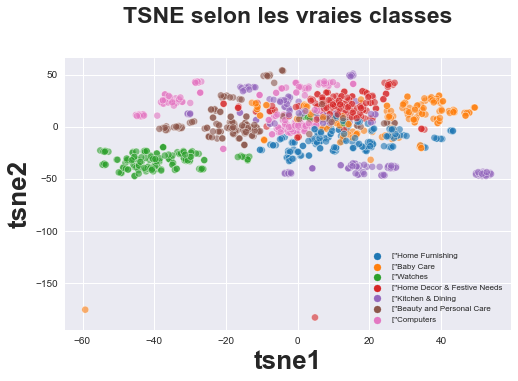

In [52]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 23, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 8},loc='best') 


plt.show()

#### 4.3.2.  Représentation des données selon les Clusters avec K-Means mini-batchs

In [53]:
# Creation de clusters T-SNE
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


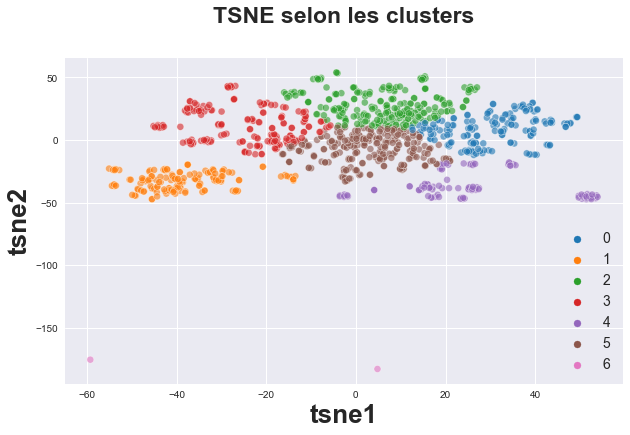

ARI :  0.3469318364022759


In [54]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 23, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data1["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

## 5. Résultats et analyses

### 5.1. Metrics (accuracy, precision, recall, F1 Score)

In [55]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 93   0  12   9   5  30   1]
 [ 10   0  11  94   0  35   0]
 [  0   2  42  52   0  54   0]
 [ 20   0 110  11   0   8   1]
 [ 31   0   2   0  17 100   0]
 [  6   0  52   9  74   9   0]
 [  0 144   0   0   0   6   0]]


In [56]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    #corresp = [4,1,2,0,5,6,3]
    print ("Correspondance des clusters : ", corresp)
    #y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [0 6 3 1 5 4 0]
[[ 94   9   0  12  30   5   0]
 [ 10  94   0  11  35   0   0]
 [  0  52   0  42  54   0   2]
 [ 21  11   0 110   8   0   0]
 [ 31   0   0   2 100  17   0]
 [  6   9   0  52   9  74   0]
 [  0   0   0   0   6   0 144]]

              precision    recall  f1-score   support

           0       0.58      0.63      0.60       150
           1       0.54      0.63      0.58       150
           2       0.00      0.00      0.00       150
           3       0.48      0.73      0.58       150
           4       0.41      0.67      0.51       150
           5       0.77      0.49      0.60       150
           6       0.99      0.96      0.97       150

    accuracy                           0.59      1050
   macro avg       0.54      0.59      0.55      1050
weighted avg       0.54      0.59      0.55      1050



C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.2. Matrice de confusion

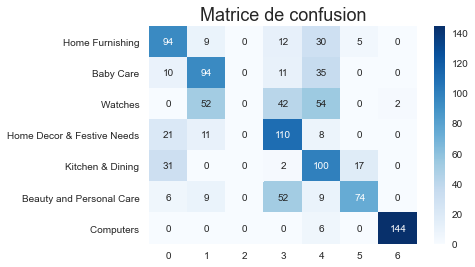

In [57]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
plt.title("Matrice de confusion", size=18)
sns.heatmap(df_cm, annot=True,  fmt="d",cmap="Blues")
plt.show()

# *PARTIE 2 : Données "IMAGES"*
* Objectif : Vérifier si nous pouvons prédire la catégorie d'un produit en fonction de sa photo

# 2. Traitement des images

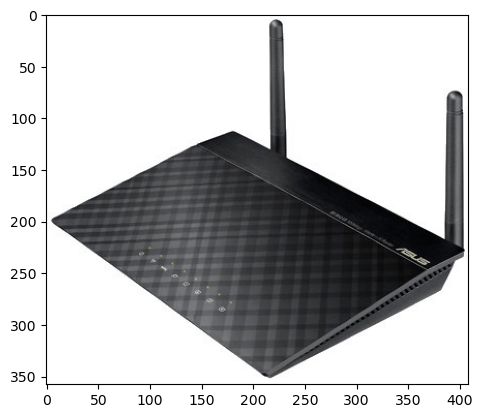

In [58]:
plt.style.use('default')
image = plt.imread("Images/394c2c627914e1eed9b8ac343583a679.jpg")
plt.imshow(image)

In [59]:
path = "C:/Users/DELL LATITUDE E7240/Documents/Openclassrooms/EXP/P6_assefy_sherali/Images/"
list_photos = [file for file in listdir(path)]
print("Nombre de photos : {}".format(len(list_photos)))

Nombre de photos : 1050


## 1. Préparation des données

### 1.1. Insertion d'une colonne avec le chemin des images dans le dataframe

In [60]:
def chemin_complet(image):
    
    '''Cette fonction permet de reformater le champs image
       afin d'avoir le chemin complet dans le but de les 
       charger plus facilement'''
    
    image = "Images/" + image
    
    return image

In [61]:
# On repart de notre dataframe df  auquel nous rajoutons les données images
df["image"] = data["image"].copy()

# On reformate la colonne image de manière à avoir le chemin complet des fichiers
df["image"] = df["image"].apply(chemin_complet)

# On reformate la colonne sous_cat_1 pour supprimer les deux premiers caractères
df["sous_cat_1"] = df["sous_cat_1"].apply(clean_sous_cat_1)

df.head()

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree        sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                         image  
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg  
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg  
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg

### 1.2.Transformation des images en niveau de gris 

In [62]:
def transform_grayscale(image):
    
    file_dir=os.path.split(image)
    
    # Conversion en niveau de gris de l'image
    img = Image.open(image).convert("L")
    
    # Egalisation de l'histogramme
    img = ImageOps.equalize(img)
    
    # Suppression du bruit avec un kernel (nombre de pixels) = 3
    img = img.filter(ImageFilter.MedianFilter(size=3))
    
    img.save("Images_grayscale/"+file_dir[1])
    
    return "Images_grayscale/"+file_dir[1]

In [63]:
# Conversion des images en niveaux de gris
df["image_grayscale"] = df["image"].apply(transform_grayscale)

C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


### 1.3.Redimensionnement des images

In [64]:
def redim_image(image):
    
    '''Cette fonction permet de redimensionner une image en tenant compte de ses proportions initiales'''
    
    # On charge l'image d'origine
    img = Image.open(image)
    file_dir=os.path.split(image)
    
    width, height = img.size
    
    # On teste si c'est une image au format
    # paysage ou portrait, ou même carrée
    
    # On récupère le côté le plus grand et on le
    # redimensionne à la taille souhaitée, ici 224.
    # Tout en gardant le ratio hauteur/largeur pour
    # l'autre côté.
    if height > width:
    
        aspect = height / 224
        new_size = (int(width/aspect), 224)
    elif width > height:
        
        aspect = width / 224
        new_size = (224, int(height/aspect))
    else:
        
        new_size = (224, 224)
    
    # On enregistre dans un nouveau dossier l'image redimensionnée.
    img.resize(new_size).save("Images_redim/"+file_dir[1])

    # Nous avons une image de taille 224xXXX ou XXXx224, or
    # notre CNN n'accepte que des images de la taille 224x224,
    # il nous faut donc retravailler la taille de l'image.
    
    # Pour cela, nous allons créer une image de taille 224x224
    # entièrement blanche, puis coller notre image redimensionnée
    # précédemment de manière centrée sur cette image blanche.
    
    img = Image.open("Images_redim/"+file_dir[1])
    
    width, height = img.size
    
    if height > width:
        new_img = Image.new('RGB', (224, 224),(255,255,255)) # white
        
        pos_lrg = int((height - width) / 2)
        new_img.paste(img, box=(pos_lrg,0))
        
        new_img.save("Images_redim/"+file_dir[1])
        
    elif width > height:
        new_img = Image.new('RGB', (224, 224),(255,255,255)) # white
        
        pos_ht = int((width - height) / 2)
        new_img.paste(img, box=(0, pos_ht))

        new_img.save("Images_redim/"+file_dir[1])
    
    
    return "Images_redim/"+file_dir[1]

In [65]:
def autocontraste(image):
    
    '''Cette fonction permet d'ajuster automatiquement le contraste d'une image.''' 
    
    img = Image.open(image)
        
    dimg = ImageOps.autocontrast(img, cutoff=0.5)
    
    file_dir=os.path.split(image)
    dimg.save("Images_redim_contrast/"+file_dir[1])
    
    return "Images_redim_contrast/"+file_dir[1]

## 2. Algorithme ORB

### 2.1. Création d'un dataframe avec les données qui nous intéressent

In [66]:
df.head(2)

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   

                               product_category_tree        sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                         image  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                     image_grayscale  
0  Images_grayscale/55b85ea15a1536d46b7190ad6fff8...  
1  Images_grayscale/7b72c92c2f6c40268628ec5f14c6d...

In [67]:
# Selection des données qui nous intéressent
data2 = df.loc[:,['image','sous_cat_1']]

# On renomme les colonnes
data2.rename(columns={'image':'image_path', 'sous_cat_1':'label_name'}, inplace=True)

In [68]:
data2.head()

image_path        label_name
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing 
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care 
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care 
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing 
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing

### Création d'une colonne "label"

In [69]:
# Affichage des labels qui composent la sous-catégorie1
data2.label_name.unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [70]:
# Création d'une liste de labels
list_labels = ['Home Furnishing ', 'Baby Care ', 'Watches ',
               'Home Decor & Festive Needs ', 'Kitchen & Dining ',
               'Beauty and Personal Care ', 'Computers ']

# Label encoding 
le = preprocessing.LabelEncoder()

# Création d'une colonne "label" avec label encoding des "label_name"
data2["label"] = le.fit_transform(data2["label_name"])
data2

image_path        label_name  label
0     Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing       4
1     Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care       0
2     Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care       0
3     Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing       4
4     Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing       4
...                                           ...               ...    ...
1045  Images/958f54f4c46b53c8a0a9b8167d9140bc.jpg        Baby Care       0
1046  Images/fd6cbcc22efb6b761bd564c28928483c.jpg        Baby Care       0
1047  Images/5912e037d12774bb73a2048f35a00009.jpg        Baby Care       0
1048  Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        Baby Care       0
1049  Images/f2f027ad6a6df617c9f125173da71e44.jpg        Baby Care       0

[1050 rows x 3 columns]

In [71]:
# Regroupement des données par label
data2.groupby("label").count()

image_path  label_name
label                        
0             150         150
1             150         150
2             150         150
3             150         150
4             150         150
5             150         150
6             150         150

## 2.2. Affichage d'exemples d'images par label

In [72]:
path = "C:/Users/DELL LATITUDE E7240/Documents/Openclassrooms/EXP/P6_assefy_sherali/Images_redim_contrast/"
list_photos = [file for file in listdir(path)]
print("Nombre de photos : {}".format(len(list_photos)))

Nombre de photos : 1050


Home Furnishing 


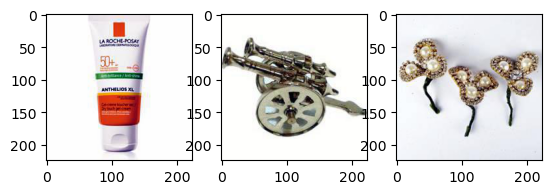

Baby Care 


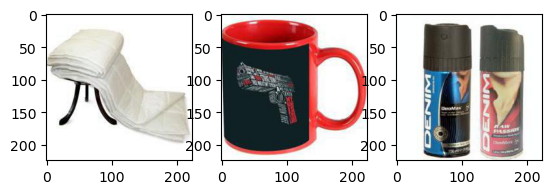

Watches 


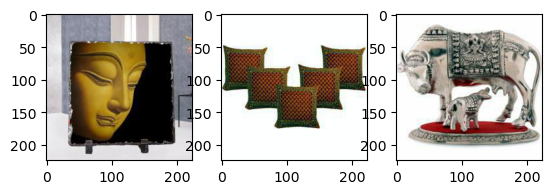

Home Decor & Festive Needs 


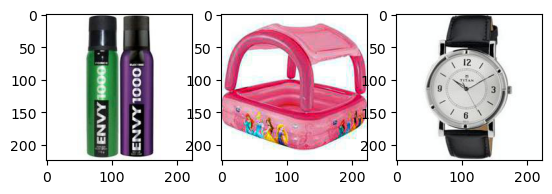

Kitchen & Dining 


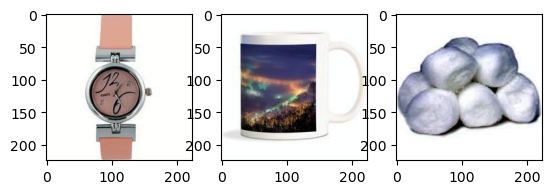

Beauty and Personal Care 


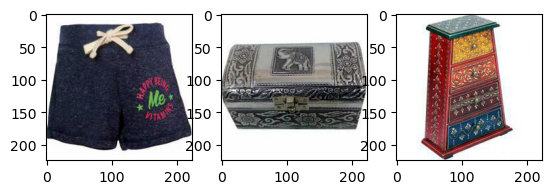

Computers 


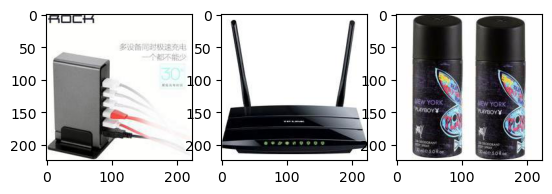

In [73]:
def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(data2)) if data2["label_name"][i]==name]
    return list_image_name

list_home_furnishing=[list_photos[i] for i in range(len(data2)) if data2["label_name"][i]=="Home Furnishing "]
list_Baby_care=[list_photos[i] for i in range(len(data2)) if data2["label_name"][i]=="Baby Care "]
list_watches=[list_photos[i] for i in range(len(data2)) if data2["label_name"][i]=="Watches "]
list_home_decor=[list_photos[i] for i in range(len(data2)) if data2["label_name"][i]=="Home Decor & Festive Needs "]
list_kitchen=[list_photos[i] for i in range(len(data2)) if data2["label_name"][i]=="Kitchen & Dining "]
list_beauty=[list_photos[i] for i in range(len(data2)) if data2["label_name"][i]=="'Beauty and Personal Care "]
list_computers=[list_photos[i] for i in range(len(data2)) if data2["label_name"][i]=="Computers "]

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

## 2.3. Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("orb_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("orb_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

### 2.3.1 Visualisation des descripteurs pour quelques images

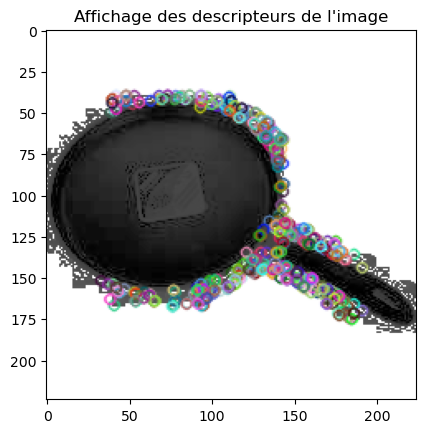

Descripteurs :  (370, 32)

[[132 205   6 ... 123 176 136]
 [ 36 237 194 ... 251 242 136]
 [116 229 194 ... 123 114 128]
 ...
 [ 39 215  99 ... 254 120 181]
 [ 57  21 122 ... 162  66 105]
 [125 105 120 ... 187  82  33]]


In [74]:
path = "C:/Users/DELL LATITUDE E7240/Documents/Openclassrooms/EXP/P6_assefy_sherali/Images_redim_contrast/"

orb = cv2.ORB_create()
image = cv2.imread(path+list_photos[1],0) # passage en gris
image = cv2.equalizeHist(image)   # equalisation des histogrammes de l'image
kp, des = orb.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.title("Affichage des descripteurs de l'image")
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


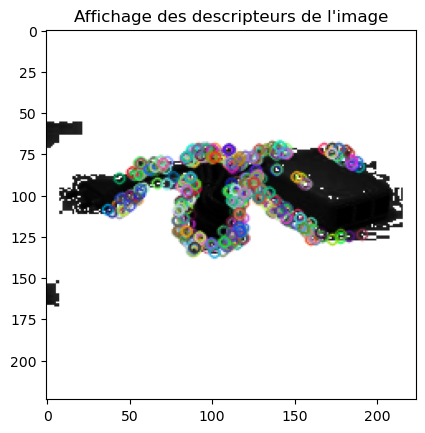

Descripteurs :  (420, 32)

[[ 90  18 118 ... 133  38 219]
 [ 32 205 198 ... 249 112 136]
 [ 32 205 194 ... 120 112 136]
 ...
 [130  92 118 ... 116  33 217]
 [162 205  98 ...  12 241 152]
 [130 204  22 ...  16 161 136]]


In [75]:
orb = cv2.ORB_create()
image = cv2.imread(path+list_photos[6],0) # passage en gris
image = cv2.equalizeHist(image)   # equalisation des histogrammes de l'image
kp, des = orb.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.title("Affichage des descripteurs de l'image")
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


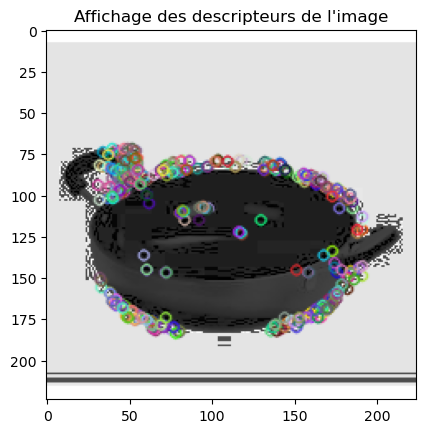

Descripteurs :  (324, 32)

[[165 181 123 ... 234 242 176]
 [124 249  61 ...   8 214  98]
 [188 116 121 ... 217 194 161]
 ...
 [ 95 127 115 ... 246 174 117]
 [ 63  83 232 ... 255 206 247]
 [ 91 123 123 ... 182  46 127]]


In [76]:
orb = cv2.ORB_create()
image = cv2.imread(path+list_photos[7],0) # passage en gris
image = cv2.equalizeHist(image)   # equalisation des histogrammes de l'image
kp, des = orb.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.title("Affichage des descripteurs de l'image")
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

### 2.3.2 Création d'une liste de descripteurs pour l'ensemble des images

In [77]:
# identification of key points and associated descriptors

orb_keypoints = []
temps1=time.time()
orb = cv2.ORB_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = orb.detectAndCompute(res, None)
    orb_keypoints.append(des)

orb_keypoints_by_img = np.asarray(orb_keypoints)
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", orb_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement ORB descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (396187, 32)
temps de traitement ORB descriptor :             5.17 secondes


## 2.4. Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [78]:
# Determination du nombre de clusters
temps1=time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(orb_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  629
Création de 629 clusters de descripteurs ...
temps de traitement kmeans :            43.04 secondes


## 2.5 Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [79]:
# Création des histogrammes (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation d'une matrice d'histogrammes
hist_vectors=[]

for i, image_desc in enumerate(orb_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calcule l'histogramme
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             3.13 secondes


## 2.6 Réductions de dimension

### 2.6.1. Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [80]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 629)
Dimensions dataset après réduction PCA :  (1050, 528)


### 2.6.2.  Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [81]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data2["label_name"]
print(df_tsne.shape)


(1050, 3)


## 2.6.3. Analyse visuelle : affichage T-SNE selon catégories d'images

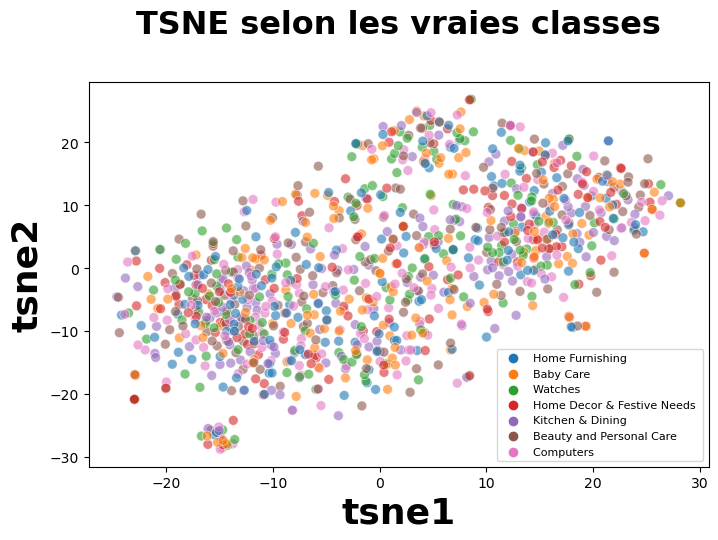

In [82]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 23, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 8},loc='best') 


plt.show()


## 2.7. Analyse mesures : similarité entre catégories et clusters

###  2.7.1. Création de clusters à partir du T-SNE

In [83]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


### 2.7.2. Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters


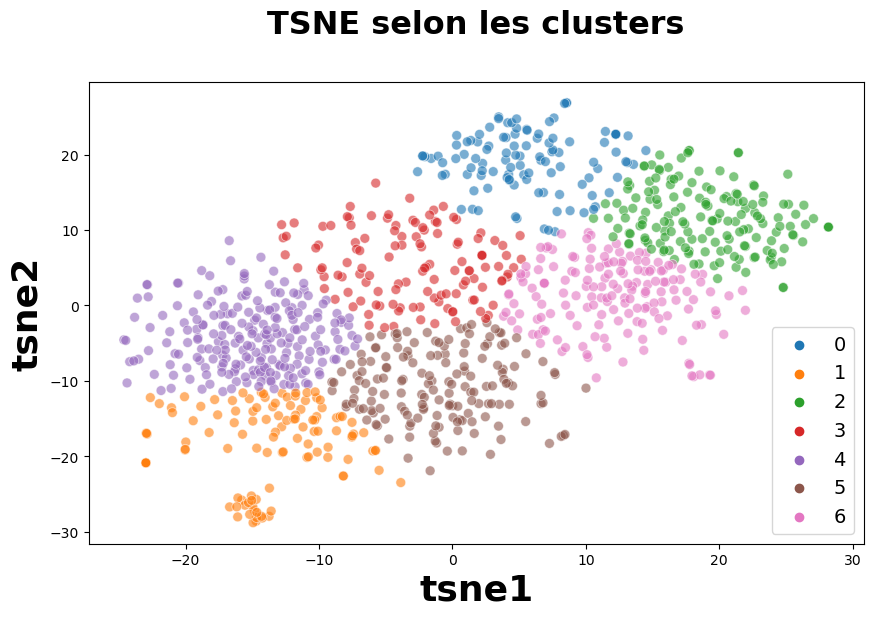

ARI :  0.0005114164343462735


In [84]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 23, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data2["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### 2.7.3. Analyse par classes

In [85]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    109
1    115
2    160
3    124
4    217
5    161
6    164
Name: class, dtype: int64

In [86]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[21 10 21 20 23 31 24]
 [15 15 21 27 35 17 20]
 [13 19 19 17 33 29 20]
 [13 14 29 13 35 19 27]
 [15 17 24 15 31 25 23]
 [11 26 27 16 25 20 25]
 [21 14 19 16 35 20 25]]


In [89]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    #corresp = [0,1,2,3,4,5,6]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [0 5 3 1 1 0 3]
[[52 43  0 45  0 10  0]
 [32 62  0 41  0 15  0]
 [42 50  0 39  0 19  0]
 [32 48  0 56  0 14  0]
 [40 46  0 47  0 17  0]
 [31 41  0 52  0 26  0]
 [41 51  0 44  0 14  0]]

              precision    recall  f1-score   support

           0       0.19      0.35      0.25       150
           1       0.18      0.41      0.25       150
           2       0.00      0.00      0.00       150
           3       0.17      0.37      0.24       150
           4       0.00      0.00      0.00       150
           5       0.23      0.17      0.20       150
           6       0.00      0.00      0.00       150

    accuracy                           0.19      1050
   macro avg       0.11      0.19      0.13      1050
weighted avg       0.11      0.19      0.13      1050



C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


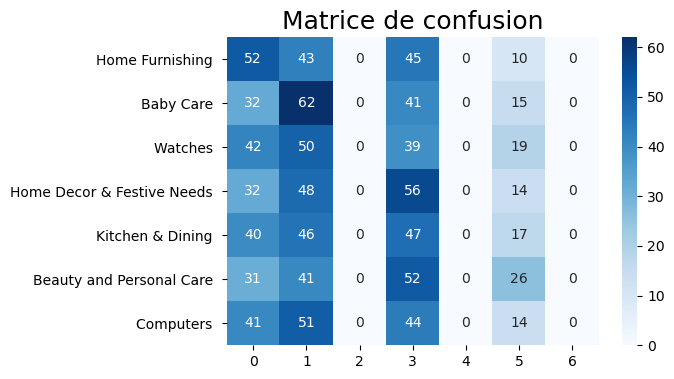

In [94]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  #columns = [i for i in "0431625"])
                   columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
plt.title("Matrice de confusion", size=18)
sns.heatmap(df_cm, annot=True,  fmt="d",cmap="Blues")
plt.show()

Conclusion : 
La méthode ORB appliquée à nos images ne donne pas de résultat.
L'ARI suite au k-means est proche de 0.
Le F1 score et l'accuracy sont faibles également.
Nous allons donc tenter une autre méthode : Transfer learning grâce à un algorithme pré-entrainé.

## 3. Transfer learning

### 3.1. Préparation des données

In [98]:
#def redim_test(image):
#    
#    ''' Cette fonction sert juste à montrer ce que donne une image redimensionnée sans prendre en compte les proportions.
#        Cela sert juste à illustrer le support de présentation du projet'''
#    
#    img = Image.open(image)
#    file_dir=os.path.split(image)
#    
#    width, height = img.size
#    
#    new_size = (224, 224)
#        
#    img.resize(new_size).save("Images_redim_test/"+file_dir[1])
#    
#    return "Images_redim_test/"+file_dir[1]

In [102]:
def affich_image(df_images):
    
    fig = plt.figure(figsize=(15, 5))
    
    columns = 5
    rows = 2
    i = 1
    
    for img in df_images["image_redim"]:
        
        plt.style.use('default')
        image = plt.imread(img)
        fig.add_subplot(rows, columns, i)
        plt.imshow(image)
        plt.axis('off')
        i += 1

In [103]:
%%time

# On redimensionne les images en 224x224 
# Sert uniquement pour le support de présentation
#for i in range(0,20):
#    redim_test(df["image"][i])

# On redimensionne les images en conservant les proportions d'origine
df["image_redim"] = df["image"].apply(redim_image)

# On redimensionne les images en conservant les proportions d'origine
df["image_redim_contrast"] = df["image_redim"].apply(autocontraste)

df.head()

C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Wall time: 58.5 s


description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree        sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                         image  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                     image_grayscale  \
0  Images_grayscale/55b85ea15a1536d46b7190ad6fff8...   
1  Images_grayscale/7b72c92c2f6c40268628ec5f14c6d...   
2  Images_grayscale/64d5d4a258243731dc7bbb1eef49a...   
3  Images_grayscale/d4684dcdc759dd9cdf41504698d73...   
4  Images_grayscale/6325b6870c54cd47be6ebfbffa620...   

                                         image_redim  \
0  Images_redim/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images_redim/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images_redim/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images_redim/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images_redim/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                image_redim_contrast  
0  Images_redim_contrast/55b85ea15a1536d46b7190ad...  
1  Images_redim_contrast/7b72c92c2f6c40268628ec5f...  
2  Images_redim_contrast/64d5d4a258243731dc7bbb1e...  
3  Images_redim_contrast/d4684dcdc759dd9cdf415046...  
4  Images_redim_contrast/6325b6870c54cd47be6ebfbf...

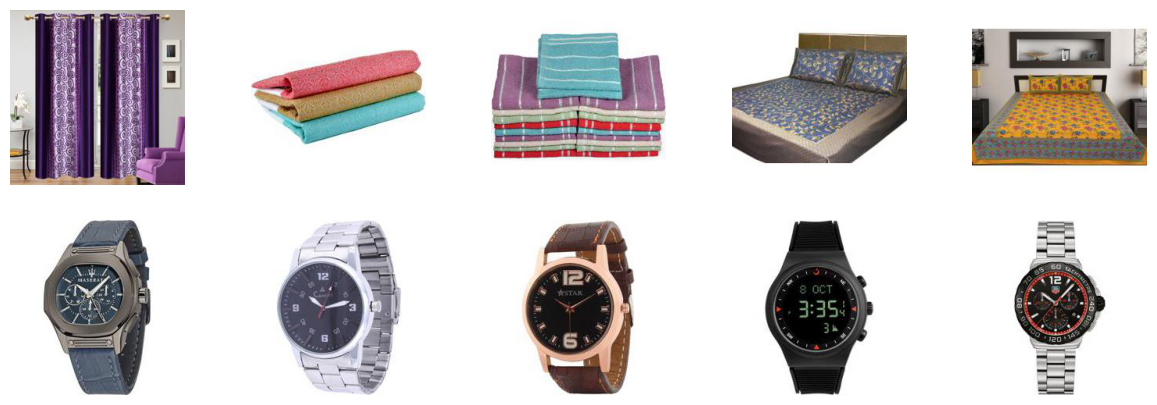

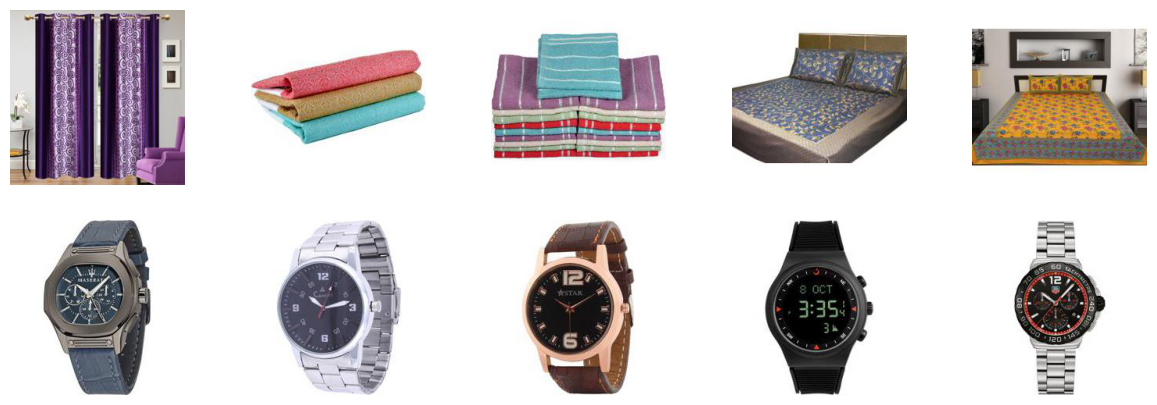

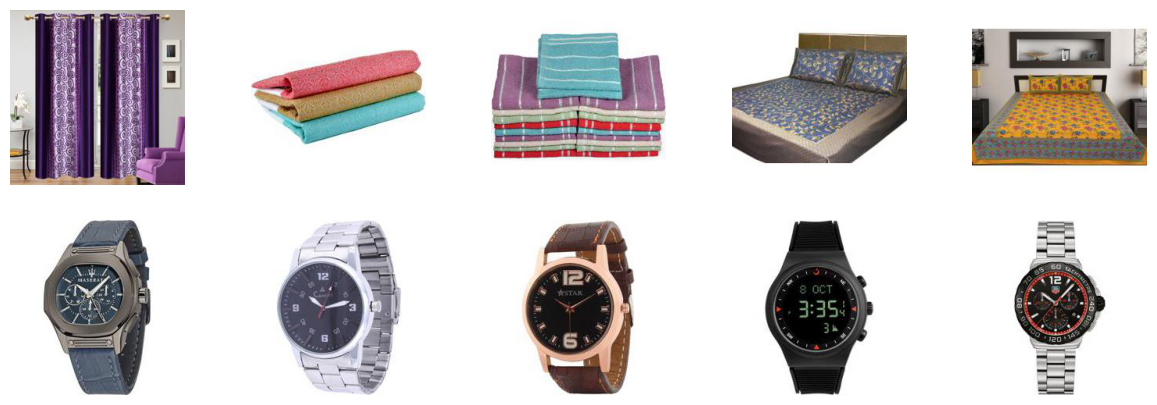

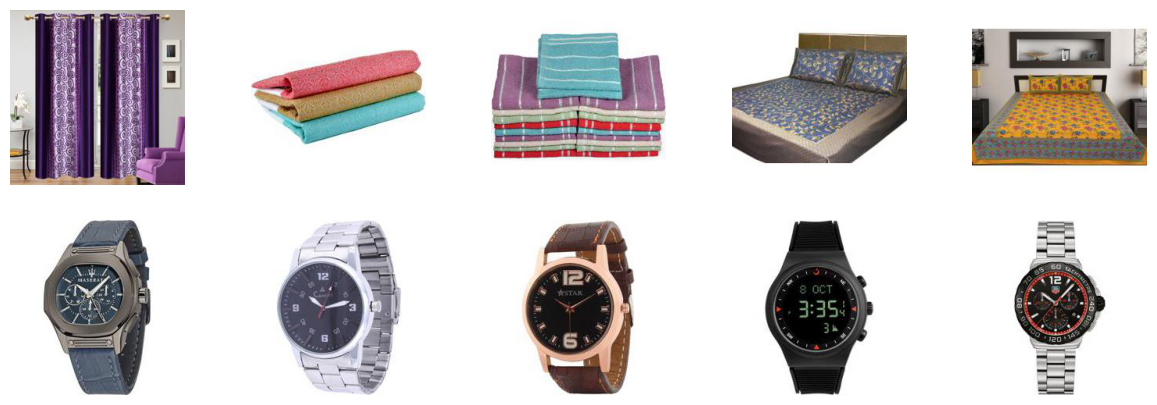

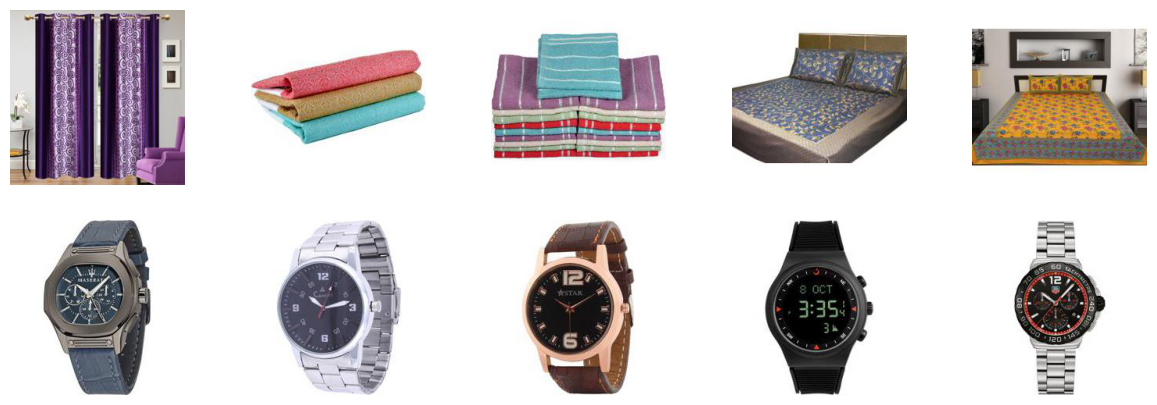

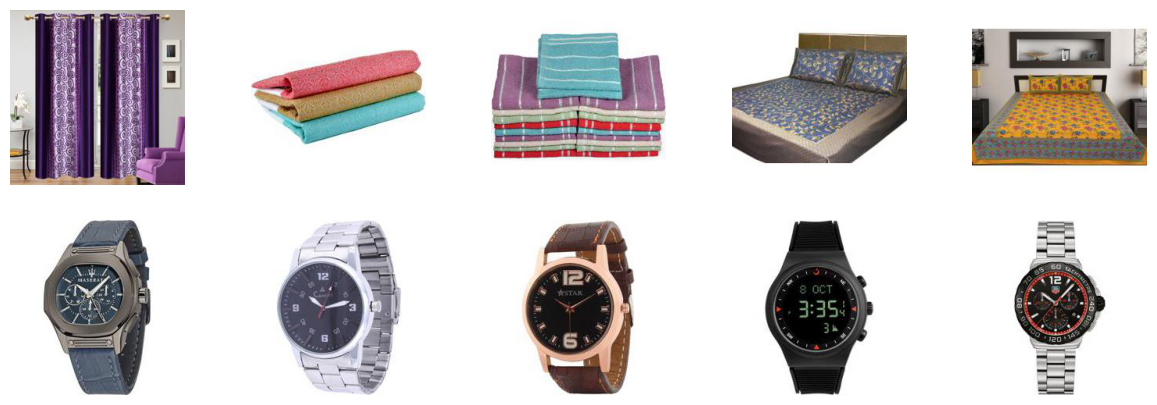

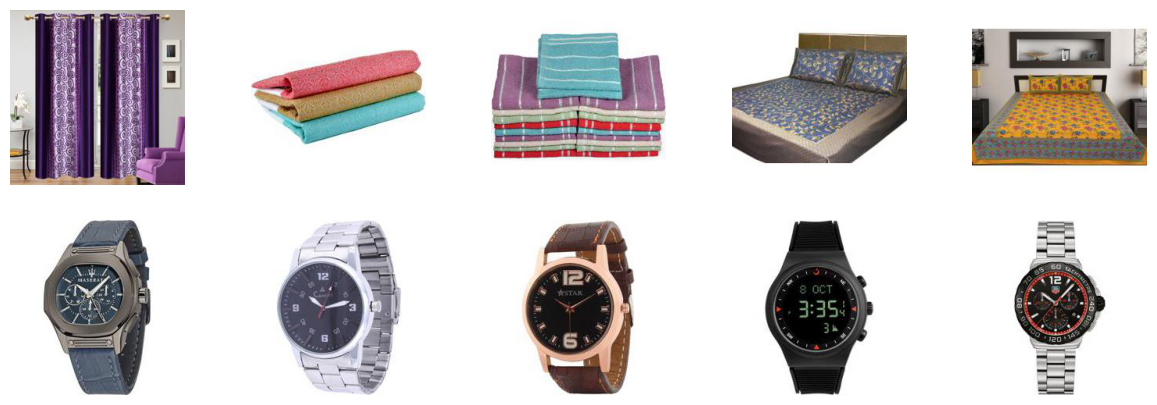

In [104]:
for cat in df["sous_cat_1"].unique():
    
    df2 = df.loc[df["sous_cat_1"] == cat]
    df2 = df[:10]
    affich_image(df2)

In [105]:
dictionary_size = 1000
# Loading images
imgs_data = []
# imreads returns a list of all images in that directory
imgs = df["image_grayscale"]
for i in range(len(imgs)):
    # create a numpy to hold the histogram for each image
    imgs_data.insert(i, np.zeros((dictionary_size, 1)))

In [106]:
df.head(1)

description  \
0  Key Features of Elegance Polyester Multicolor ...   

                               product_category_tree        sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                         image  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                     image_grayscale  \
0  Images_grayscale/55b85ea15a1536d46b7190ad6fff8...   

                                         image_redim  \
0  Images_redim/55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                image_redim_contrast  
0  Images_redim_contrast/55b85ea15a1536d46b7190ad...

In [107]:
# Selection des données qui nous intéressent
data3 = df.loc[:,['image_redim_contrast','sous_cat_1']]

# On renomme les colonnes
data3.rename(columns={'image_redim_contrast':'image_path', 'sous_cat_1':'label_name'}, inplace=True)



In [108]:
# Création d'une liste de labels
list_labels = ['Home Furnishing ', 'Baby Care ', 'Watches ',
               'Home Decor & Festive Needs ', 'Kitchen & Dining ',
               'Beauty and Personal Care ', 'Computers ']

# Label encoding 
le = preprocessing.LabelEncoder()

# Création d'une colonne "label" avec label encoding des "label_name"
data3["label"] = le.fit_transform(data3["label_name"])
data3

image_path        label_name  \
0     Images_redim_contrast/55b85ea15a1536d46b7190ad...  Home Furnishing    
1     Images_redim_contrast/7b72c92c2f6c40268628ec5f...        Baby Care    
2     Images_redim_contrast/64d5d4a258243731dc7bbb1e...        Baby Care    
3     Images_redim_contrast/d4684dcdc759dd9cdf415046...  Home Furnishing    
4     Images_redim_contrast/6325b6870c54cd47be6ebfbf...  Home Furnishing    
...                                                 ...               ...   
1045  Images_redim_contrast/958f54f4c46b53c8a0a9b816...        Baby Care    
1046  Images_redim_contrast/fd6cbcc22efb6b761bd564c2...        Baby Care    
1047  Images_redim_contrast/5912e037d12774bb73a2048f...        Baby Care    
1048  Images_redim_contrast/c3edc504d1b4f0ba6224fa53...        Baby Care    
1049  Images_redim_contrast/f2f027ad6a6df617c9f12517...        Baby Care    

      label  
0         4  
1         0  
2         0  
3         4  
4         4  
...     ...  
1045      0  
1046      0  
1047      0  
1048      0  
1049      0  

[1050 rows x 3 columns]

### 3.2. Chargement d'un modèle pré-entrainé VGG16

In [109]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np


model = VGG16(weights='imagenet', include_top=False)
model.summary()

img_path = "Images_redim_contrast/55b85ea15a1536d46b7190ad6fff8ce7.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

vgg16_feature = model.predict(img_data)

print(vgg16_feature.shape)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [110]:
data3.head(1)

image_path        label_name  label
0  Images_redim_contrast/55b85ea15a1536d46b7190ad...  Home Furnishing       4

In [111]:
vgg16_feature_list = []

for img_path in data3["image_path"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())
        
vgg16_feature_list_np = np.array(vgg16_feature_list)

In [112]:
print("Dimension vecteur par image :", len(vgg16_feature_list_np[0]))
print("Nombre total de vecteurs :", len(vgg16_feature_list_np))

Dimension vecteur par image : 25088
Nombre total de vecteurs : 1050


In [130]:
# Intégration de la colonne VGG16 dans df
df["VGG16"] =  ""

for i in range(df.shape[0]):
    df["VGG16"][i] = vgg16_feature_list_np[i]


description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree        sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                         image  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                     image_grayscale  \
0  Images_grayscale/55b85ea15a1536d46b7190ad6fff8...   
1  Images_grayscale/7b72c92c2f6c40268628ec5f14c6d...   
2  Images_grayscale/64d5d4a258243731dc7bbb1eef49a...   
3  Images_grayscale/d4684dcdc759dd9cdf41504698d73...   
4  Images_grayscale/6325b6870c54cd47be6ebfbffa620...   

                                         image_redim  \
0  Images_redim/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images_redim/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images_redim/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images_redim/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images_redim/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                image_redim_contrast  \
0  Images_redim_contrast/55b85ea15a1536d46b7190ad...   
1  Images_redim_contrast/7b72c92c2f6c40268628ec5f...   
2  Images_redim_contrast/64d5d4a258243731dc7bbb1e...   
3  Images_redim_contrast/d4684dcdc759dd9cdf415046...   
4  Images_redim_contrast/6325b6870c54cd47be6ebfbf...   

                                               VGG16  
0  [0.0, 0.0, 0.0, 0.0, 8.8258, 0.0, 0.0, 0.0, 0....  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [113]:
data3["VGG16"] =  ""

for i in range(data3.shape[0]):
    data3["VGG16"][i] = vgg16_feature_list_np[i]

data3.head()

<ipython-input-113-75dac7ff355a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3["VGG16"][i] = vgg16_feature_list_np[i]


image_path        label_name  label  \
0  Images_redim_contrast/55b85ea15a1536d46b7190ad...  Home Furnishing       4   
1  Images_redim_contrast/7b72c92c2f6c40268628ec5f...        Baby Care       0   
2  Images_redim_contrast/64d5d4a258243731dc7bbb1e...        Baby Care       0   
3  Images_redim_contrast/d4684dcdc759dd9cdf415046...  Home Furnishing       4   
4  Images_redim_contrast/6325b6870c54cd47be6ebfbf...  Home Furnishing       4   

                                               VGG16  
0  [0.0, 0.0, 0.0, 0.0, 8.8258, 0.0, 0.0, 0.0, 0....  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [114]:
# Dimension du dataset avant et après réduction de dimension avec un PCA
print("Dimensions dataset avant réduction PCA : ", vgg16_feature_list_np.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(vgg16_feature_list_np)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 25088)
Dimensions dataset après réduction PCA :  (1050, 938)


In [115]:
# Réduction de dimension avec T-SNE
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data3["label_name"]
print(df_tsne.shape)

(1050, 3)


### 3.3. Résultats et analyses

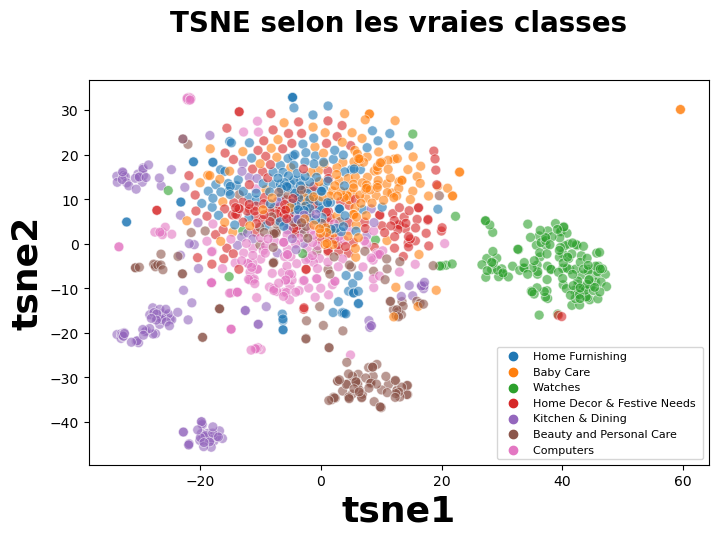

In [128]:
# Affichage selon les vraies classes
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 8},loc='best') 


plt.show()


In [117]:
cls = cluster.KMeans(n_clusters=7, random_state=0)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


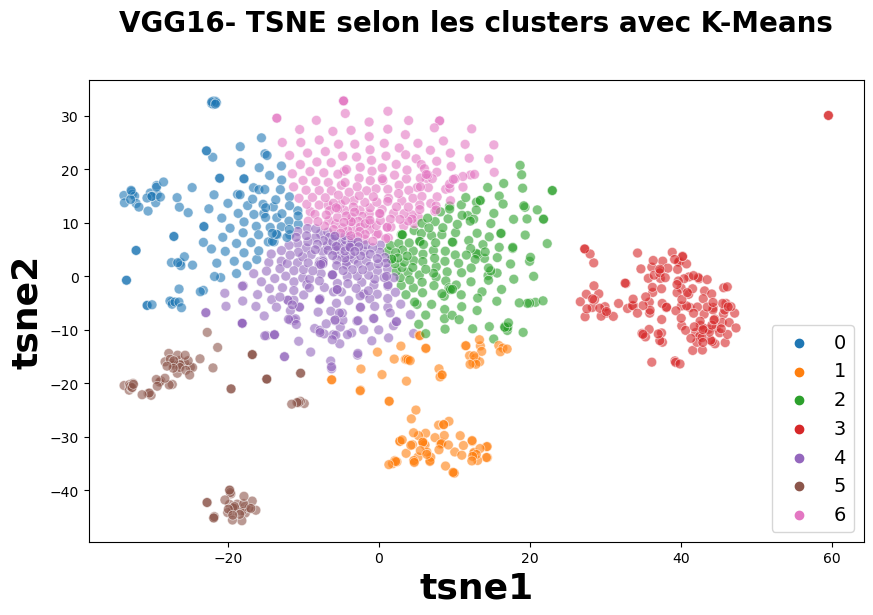

ARI :  0.3006557538719144


In [127]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('VGG16- TSNE selon les clusters avec K-Means', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data3["label_name"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [119]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    132
1    102
2    165
3    143
4    219
5     91
6    198
Name: class, dtype: int64

In [122]:
conf_mat = metrics.confusion_matrix(data3["label"], cls.labels_)
print(conf_mat)

[[ 10   2  49   2  13   0  74]
 [ 16  82  11   0  30   5   6]
 [ 18   1  22   0  98   8   3]
 [ 24   0  51   2  38   0  35]
 [ 29  12  15   0  18   0  76]
 [ 34   5  11   0  19  78   3]
 [  1   0   6 139   3   0   1]]


In [125]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    #corresp = [4,2,1,0,5,6,3]
    print ("Correspondance des clusters : ", corresp)
    #y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    y_true = data3["label"]
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(data3["label"], cls.labels_)
conf_mat = metrics.confusion_matrix(data3["label"], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(data3["label"], cls_labels_transform))

Correspondance des clusters :  [5 1 3 6 2 5 4]
[[  0   2  13  49  74  10   2]
 [  0  82  30  11   6  21   0]
 [  0   1  98  22   3  26   0]
 [  0   0  38  51  35  24   2]
 [  0  12  18  15  76  29   0]
 [  0   5  19  11   3 112   0]
 [  0   0   3   6   1   1 139]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.80      0.55      0.65       150
           2       0.45      0.65      0.53       150
           3       0.31      0.34      0.32       150
           4       0.38      0.51      0.44       150
           5       0.50      0.75      0.60       150
           6       0.97      0.93      0.95       150

    accuracy                           0.53      1050
   macro avg       0.49      0.53      0.50      1050
weighted avg       0.49      0.53      0.50      1050



C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


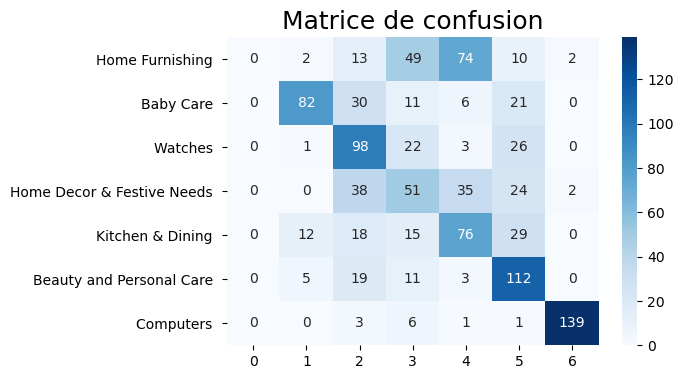

In [126]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
plt.title("Matrice de confusion", size=18)
sns.heatmap(df_cm, annot=True, fmt="d",cmap="Blues")
plt.show()

In [129]:
df.head()

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree        sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                         image  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                     image_grayscale  \
0  Images_grayscale/55b85ea15a1536d46b7190ad6fff8...   
1  Images_grayscale/7b72c92c2f6c40268628ec5f14c6d...   
2  Images_grayscale/64d5d4a258243731dc7bbb1eef49a...   
3  Images_grayscale/d4684dcdc759dd9cdf41504698d73...   
4  Images_grayscale/6325b6870c54cd47be6ebfbffa620...   

                                         image_redim  \
0  Images_redim/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images_redim/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images_redim/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images_redim/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images_redim/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                image_redim_contrast  
0  Images_redim_contrast/55b85ea15a1536d46b7190ad...  
1  Images_redim_contrast/7b72c92c2f6c40268628ec5f...  
2  Images_redim_contrast/64d5d4a258243731dc7bbb1e...  
3  Images_redim_contrast/d4684dcdc759dd9cdf415046...  
4  Images_redim_contrast/6325b6870c54cd47be6ebfbf...

# PARTIE 3 : Combinaison texte + image

In [ ]:
# Récupération des données vectorielles

In [149]:
def extract_data(col):
    
    v = np.column_stack(df[col].values.tolist())
    data4 = pd.DataFrame(v).T
    
    return data4

In [150]:
df_tfidf = extract_data("tf_idf")
df_vgg16 = extract_data("VGG16")

print("Taille vecteurs tfidf :", df_tfidf.shape[1])
print("Taille vecteurs VGG16 :", df_vgg16.shape[1])

Taille vecteurs tfidf : 2371
Taille vecteurs VGG16 : 25088


In [151]:
df2 = pd.concat([df_tfidf, df_vgg16], axis=1, ignore_index=True)


In [152]:
# Construction jeu de données

In [153]:
df.head(1)

description  \
0  Key Features of Elegance Polyester Multicolor ...   

                               product_category_tree        sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                         image  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                     image_grayscale  \
0  Images_grayscale/55b85ea15a1536d46b7190ad6fff8...   

                                         image_redim  \
0  Images_redim/55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                image_redim_contrast  \
0  Images_redim_contrast/55b85ea15a1536d46b7190ad...   

                                               VGG16  
0  [0.0, 0.0, 0.0, 0.0, 8.8258, 0.0, 0.0, 0.0, 0....

In [154]:
# Selection des données qui nous intéressent
data4 = df.loc[:,['sous_cat_1','tf_idf','VGG16']]

# On renomme les colonnes
data4.rename(columns={'sous_cat_1':'label_name'}, inplace=True)

# Création d'une liste de labels
list_labels = ['Home Furnishing ', 'Baby Care ', 'Watches ',
               'Home Decor & Festive Needs ', 'Kitchen & Dining ',
               'Beauty and Personal Care ', 'Computers ']

# Label encoding 
le = preprocessing.LabelEncoder()

# Création d'une colonne "label" avec label encoding des "label_name"
data4["label"] = le.fit_transform(data3["label_name"])
data4



label_name                                             tf_idf  \
0     Home Furnishing   [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1           Baby Care   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2           Baby Care   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3     Home Furnishing   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4     Home Furnishing   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                ...                                                ...   
1045        Baby Care   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1046        Baby Care   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1047        Baby Care   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1048        Baby Care   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1049        Baby Care   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                  VGG16  label  
0     [0.0, 0.0, 0.0, 0.0, 8.8258, 0.0, 0.0, 0.0, 0....      4  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      4  
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      4  
...                                                 ...    ...  
1045  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  
1046  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  
1047  [0.0, 31.598589, 0.0, 0.0, 6.4081283, 5.149060...      0  
1048  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  
1049  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  

[1050 rows x 4 columns]

In [155]:
# Dimension du dataset avant et après réduction de dimension avec un PCA
print("Dimensions dataset avant réduction PCA : ", df2.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(df2)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 27459)
Dimensions dataset après réduction PCA :  (1050, 938)


In [156]:
# Réduction de dimension avec T-SNE
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data4["label_name"]
print(df_tsne.shape)

(1050, 3)


In [157]:
### 3.3. Résultats et analyses

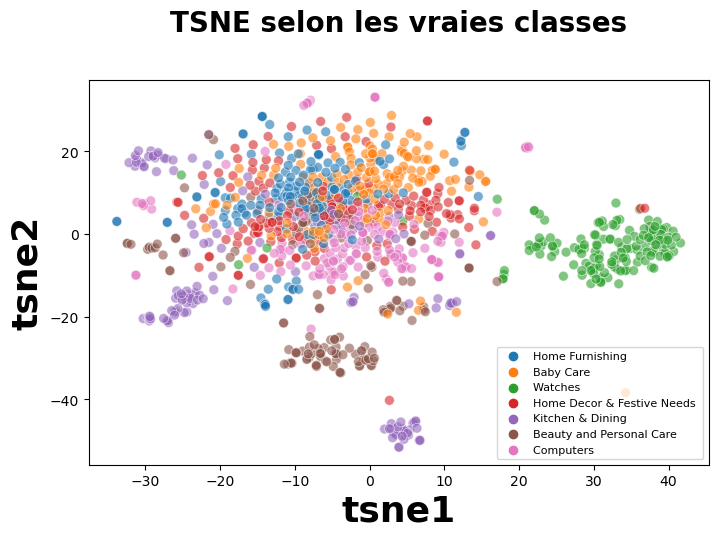

In [158]:
# Affichage selon les vraies classes
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 8},loc='best') 


plt.show()


In [159]:
cls = cluster.KMeans(n_clusters=7, random_state=0)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


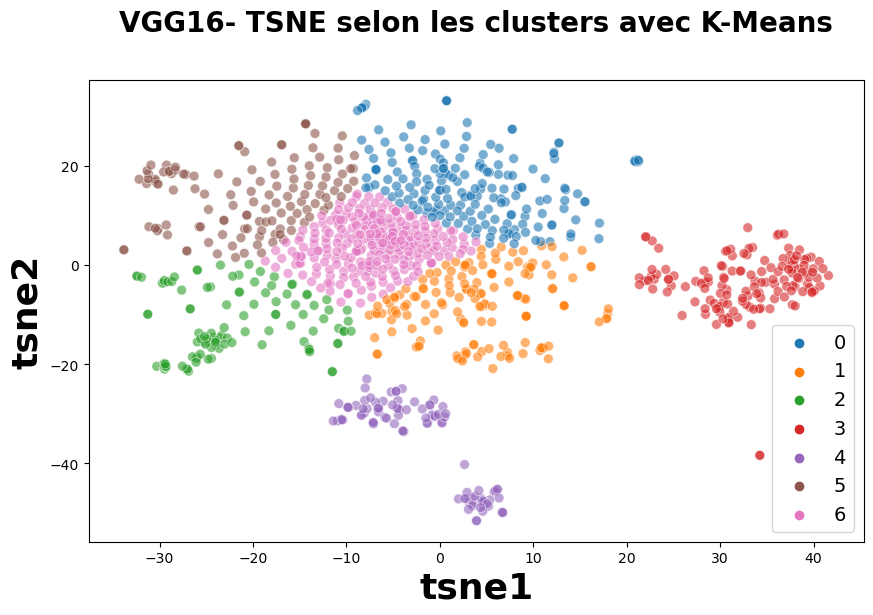

ARI :  0.25


In [170]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('VGG16- TSNE selon les clusters avec K-Means', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data4["label_name"]
print("ARI : ", round(metrics.adjusted_rand_score(labels, cls.labels_),2))

In [161]:
df_tsne.groupby("cluster").count()["class"]


cluster
0    185
1    152
2    108
3    143
4     94
5    124
6    244
Name: class, dtype: int64

In [162]:
conf_mat = metrics.confusion_matrix(data3["label"], cls.labels_)
print(conf_mat)

[[ 89   8   1   2   0  17  33]
 [  1  34  21   0  61   4  29]
 [ 16  72   8   0   1   8  45]
 [ 45  13  10   2   1  23  56]
 [ 33   0  14   0   0  40  63]
 [  0  20  53   0  31  31  15]
 [  1   5   1 139   0   1   3]]


In [163]:
cls_labels_transform = conf_mat_transform(data4["label"], cls.labels_)
conf_mat = metrics.confusion_matrix(data4["label"], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(data4["label"], cls_labels_transform))

Correspondance des clusters :  [0 2 5 6 1 4 4]
[[ 89   0   8   0  50   1   2]
 [  1  61  34   0  33  21   0]
 [ 16   1  72   0  53   8   0]
 [ 45   1  13   0  79  10   2]
 [ 33   0   0   0 103  14   0]
 [  0  31  20   0  46  53   0]
 [  1   0   5   0   4   1 139]]

              precision    recall  f1-score   support

           0       0.48      0.59      0.53       150
           1       0.65      0.41      0.50       150
           2       0.47      0.48      0.48       150
           3       0.00      0.00      0.00       150
           4       0.28      0.69      0.40       150
           5       0.49      0.35      0.41       150
           6       0.97      0.93      0.95       150

    accuracy                           0.49      1050
   macro avg       0.48      0.49      0.47      1050
weighted avg       0.48      0.49      0.47      1050



C:\Users\DELL LATITUDE E7240\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


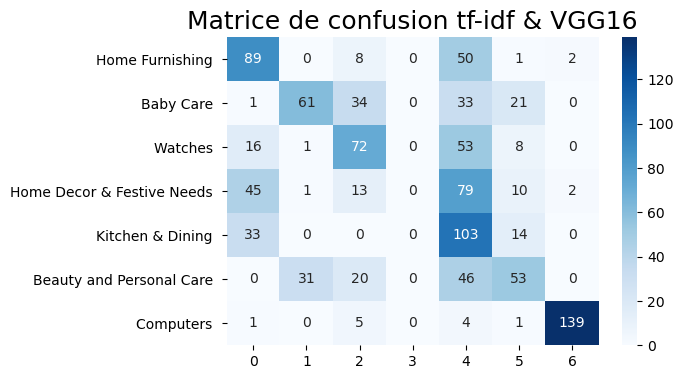

In [164]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
plt.title("Matrice de confusion tf-idf & VGG16", size=18)
sns.heatmap(df_cm, annot=True, fmt="d",cmap="Blues")
plt.show()